In [116]:
import numpy as np
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

class mlp:
    """A Multi-Layer Perceptron"""

    def __init__(
        self, inputs, targets, nhidden, beta=1, momentum=0.9, outtype="logistic"
    ):
        """Constructor"""
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype

        # Initialise network
        self.weights1 = (
            (np.random.rand(self.nin + 1, self.nhidden) - 0.5) * 2 / np.sqrt(self.nin)
        )
        self.weights2 = (
            (np.random.rand(self.nhidden + 1, self.nout) - 0.5)
            * 2
            / np.sqrt(self.nhidden)
        )

    def earlystopping(
        self, inputs, targets, valid, validtargets, eta, niterations=10000
    ):

        valid = np.concatenate((valid, -np.ones((np.shape(valid)[0], 1))), axis=1)

        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000

        print("No. of neurons in hidden layers = ", self.nhidden)
        while ((old_val_error1 - new_val_error) > 0.001) or (
            (old_val_error2 - old_val_error1) > 0.001
        ):
            self.mlptrain(inputs, targets, eta, niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid)
            new_val_error = 0.5 * np.sum((validtargets - validout) ** 2)

        print("Stopped, error = ", new_val_error)
        return new_val_error

    def mlptrain(self, inputs, targets, eta, niterations):
        """Train the neural network"""
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs, -np.ones((self.ndata, 1))), axis=1)
        change = range(self.ndata)

        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))

        for n in range(niterations):

            self.outputs = self.mlpfwd(inputs)

            error = 0.5 * np.sum((self.outputs - targets) ** 2)

            # Different types of output neurons and their activation functions
            if self.outtype == "linear":
                deltao = (self.outputs - targets) / self.ndata
            elif self.outtype == "logistic":
                deltao = (
                    self.beta
                    * (self.outputs - targets)
                    * self.outputs
                    * (1.0 - self.outputs)
                )
            elif self.outtype == "softmax":
                deltao = (
                    (self.outputs - targets)
                    * (self.outputs * (-self.outputs) + self.outputs)
                    / self.ndata
                )
            elif self.outtype == "tanh":
                deltao = (
                    (self.outputs - targets)
                    * (1.0 - np.power(self.outputs, 2))
                )
            else:
                print("error")

            # hidden network delta
            deltah = (
                self.hidden
                * self.beta
                * (1.0 - self.hidden)
                * (np.dot(deltao, np.transpose(self.weights2)))
            )

            updatew1 = (
                eta * (np.dot(np.transpose(inputs), deltah[:, :-1]))
                + self.momentum * updatew1
            )
            updatew2 = (
                eta * (np.dot(np.transpose(self.hidden), deltao))
                + self.momentum * updatew2
            )
            self.weights1 -= updatew1
            self.weights2 -= updatew2

            return error

    def mlpfwd(self, inputs):
        """Run the network forward"""

        self.hidden = np.dot(inputs, self.weights1)
        self.hidden = 1.0 / (1.0 + np.exp(-self.beta * self.hidden))
        self.hidden = np.concatenate(
            (self.hidden, -np.ones((np.shape(inputs)[0], 1))), axis=1
        )

        outputs = np.dot(self.hidden, self.weights2)

        # Different types of output neurons
        if self.outtype == "linear":
            return outputs
        elif self.outtype == "logistic":
            return 1.0 / (1.0 + np.exp(-self.beta * outputs))
        elif self.outtype == "softmax":
            normalisers = np.sum(np.exp(outputs), axis=1) * np.ones(
                (1, np.shape(outputs)[0])
            )
            return np.transpose(np.transpose(np.exp(outputs)) / normalisers)
        elif self.outtype == "tanh":
            return tanh(outputs)
        else:
            print("error")

    def confmat(self, inputs, targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs, -np.ones((np.shape(inputs)[0], 1))), axis=1)
        outputs = self.mlpfwd(inputs)

        nclasses = np.shape(targets)[1]

        if nclasses == 1:
            nclasses = 2
            outputs = np.where(outputs > 0.5, 1, 0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs, 1)
            targets = np.argmax(targets, 1)

        cm = np.zeros((nclasses, nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i, j] = np.sum(
                    np.where(outputs == i, 1, 0) * np.where(targets == j, 1, 0)
                )
        output = cm
        print("Percentage Correct: ", np.trace(cm) / np.sum(cm) * 100)
        return output


In [117]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def displayConfusionMatrix(cm, plt):
    out_cm = np.array(cm)
    df_cm = pd.DataFrame(out_cm)
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 14})  # font size
        

In [118]:
from sklearn.metrics import classification_report
def printClassificationReport(network, test, testt):
    targets=testt
    inputs = np.concatenate((test, -np.ones((np.shape(test)[0], 1))), axis=1)
    nclasses = np.shape(targets)[1]
    output = network.mlpfwd(inputs)
    if nclasses == 1:
        nclasses = 2
        output = np.where(output > 0.5, 1, 0)
    else:
        # 1-of-N encoding
        output = np.argmax(output, 1)
        targets = np.argmax(targets, 1)


    print(classification_report(targets, output))

# loading data

In [150]:
#loading data
dataset = np.loadtxt('diabetes.csv',delimiter=',')
no_of_columns = 8
#normalizing the input
dataset[:,:no_of_columns] = dataset[:,:no_of_columns]-dataset[:,:no_of_columns].mean(axis=0)
imax = np.concatenate((dataset.max(axis=0)
        *np.ones((1,no_of_columns+1)),np.abs(dataset.min(axis=0)
        *np.ones((1,no_of_columns+1)))),axis=0).max(axis=0)
dataset[:,:no_of_columns] = dataset[:,:no_of_columns]/imax[:no_of_columns]

In [120]:
print(dataset.shape)

(768, 9)


In [121]:

# Split into training, validation, and test sets
target = np.zeros((np.shape(dataset)[0],2))
indices = np.where(dataset[:,no_of_columns]==0) 
target[indices,0] = 1
indices = np.where(dataset[:,no_of_columns]==1)
target[indices,1] = 1

# Randomly order the data
order = np.arange(np.shape(dataset)[0])

np.random.shuffle(order)
dataset = dataset[order,:]
target = target[order,:]

train = dataset[::2,0:no_of_columns]
traint = target[::2]
valid = dataset[1::4,0:no_of_columns]
validt = target[1::4]
test = dataset[3::4,0:no_of_columns]
testt = target[3::4]

print (train.max(axis=0), train.min(axis=0))


[1.         0.64606288 0.64965237 1.         0.78334653 1.
 1.         1.        ] [-0.29228942 -1.         -1.         -0.26173249 -0.1041496  -0.91127677
 -0.20218239 -0.2563047 ]


# Find the number of neurons
## using sigmoid function

In [122]:
print("Using Sigmoid function")
acc = np.zeros(30)
err = np.zeros(30)
cm = []
net = []
for i in range(30):
    net.append(mlp(train,traint,i+1, outtype='logistic'))
    err[i] = net[i].earlystopping(train,traint,valid,validt,0.001)
    #err = net.mlptrain(train, traint, 0.25, 10000)
    cm.append(net[i].confmat(test,testt))
    acc[i]= np.trace(cm[i]) / np.sum(cm[i]) * 100
    

Using Sigmoid function
No. of neurons in hidden layers =  1
Stopped, error =  31.96408393423567
Percentage Correct:  78.125
No. of neurons in hidden layers =  2
Stopped, error =  32.141457877281724
Percentage Correct:  78.64583333333334
No. of neurons in hidden layers =  3
Stopped, error =  32.05194270972359
Percentage Correct:  78.125
No. of neurons in hidden layers =  4
Stopped, error =  32.03907183671007
Percentage Correct:  77.60416666666666
No. of neurons in hidden layers =  5
Stopped, error =  40.08901398288113
Percentage Correct:  60.416666666666664
No. of neurons in hidden layers =  6
Stopped, error =  31.925990650243744
Percentage Correct:  78.64583333333334
No. of neurons in hidden layers =  7
Stopped, error =  32.00489866495896
Percentage Correct:  78.125
No. of neurons in hidden layers =  8
Stopped, error =  31.78464734045605
Percentage Correct:  78.125
No. of neurons in hidden layers =  9
Stopped, error =  31.87656688028156
Percentage Correct:  78.64583333333334
No. of neu

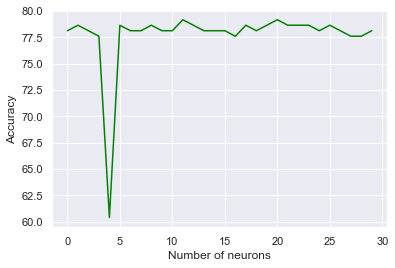

In [123]:
plt.xlabel("Number of neurons") 
plt.ylabel("Accuracy") 
plt.plot(acc, color='green')
plt.show()

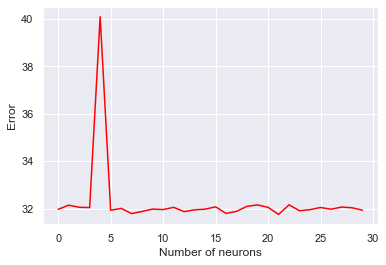

In [124]:
plt.xlabel("Number of neurons") 
plt.ylabel("Error") 
plt.plot(err, color='red')
plt.show()

In [125]:
n = np.argmax(acc)
print("Number of neurons for maximum accuracy =", n)
print("Accuracy = ", acc[n])

Number of neurons for maximum accuracy = 11
Accuracy =  79.16666666666666


In [126]:
cm[n]

array([[101.,  25.],
       [ 15.,  51.]])

Using sigmoid function


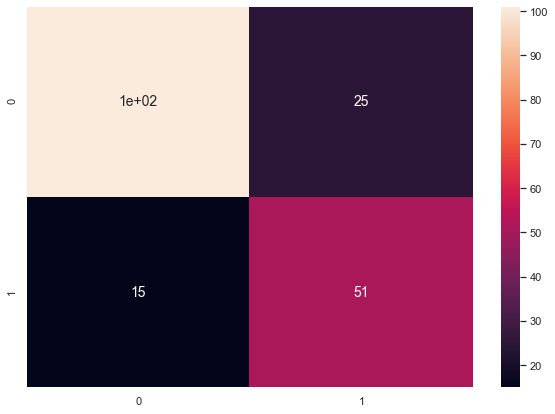

In [127]:
print("Using sigmoid function")
displayConfusionMatrix(cm[n],plt)
plt.show()

In [128]:
print("Classification report using sigmoid activation function")
printClassificationReport(net[n], test, testt)

Classification report using sigmoid activation function
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       116
           1       0.77      0.67      0.72        76

    accuracy                           0.79       192
   macro avg       0.79      0.77      0.78       192
weighted avg       0.79      0.79      0.79       192



# softmax activation function

In [139]:
print("Using Softmax activation function")
softnet = mlp(train,traint,n, outtype='softmax')
softnet.earlystopping(train,traint,valid,validt,0.25)
softcm = softnet.confmat(test, testt)

Using Softmax activation function
No. of neurons in hidden layers =  11
Stopped, error =  32.36775940519345
Percentage Correct:  79.16666666666666


Using softmax function


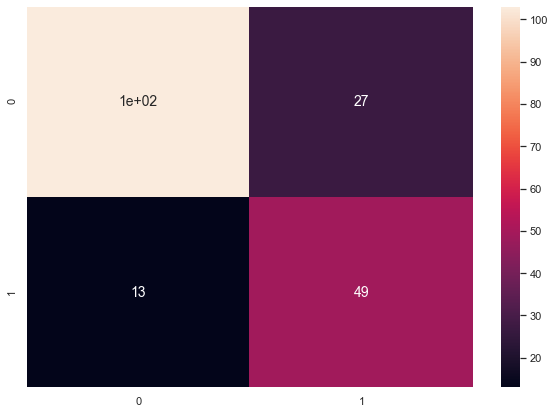

In [140]:
print("Using softmax function")
displayConfusionMatrix(softcm,plt)
plt.show()

In [141]:
print("Classification report using Softmax activation function")
printClassificationReport(softnet, test, testt)

Classification report using Softmax activation function
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       116
           1       0.79      0.64      0.71        76

    accuracy                           0.79       192
   macro avg       0.79      0.77      0.77       192
weighted avg       0.79      0.79      0.79       192



# Linear activation function 

In [132]:
print("Using Linear activation function")
signet = mlp(train,traint,n, outtype='linear')
signet.earlystopping(train,traint,valid,validt,0.25)
sigcm = signet.confmat(test, testt)

Using Linear activation function
No. of neurons in hidden layers =  11
Stopped, error =  32.38248436034704
Percentage Correct:  77.60416666666666


Using linear activation function


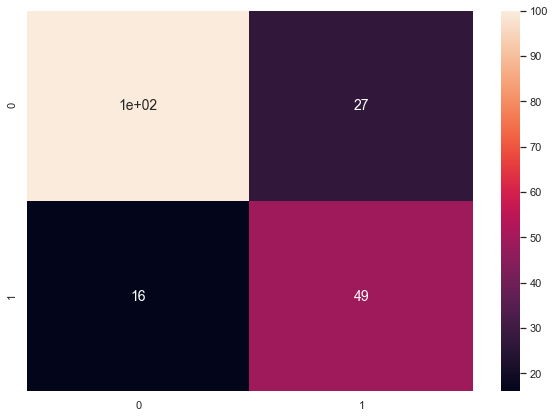

In [133]:
print("Using linear activation function")
displayConfusionMatrix(sigcm,plt)
plt.show()

In [134]:
print("Classification report using linear activation function")
printClassificationReport(signet, test, testt)

Classification report using linear activation function
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       116
           1       0.75      0.64      0.70        76

    accuracy                           0.78       192
   macro avg       0.77      0.75      0.76       192
weighted avg       0.77      0.78      0.77       192



# Tanh activation function 

In [147]:
print("Using tanh activation function")
tanhnet = mlp(train,traint,n, outtype='tanh')
#tanhnet.mlptrain(train, traint, 0.25, 20000)
tanhnet.earlystopping(train,traint,valid,validt,0.0001)
tanhcm = tanhnet.confmat(test, testt)

Using tanh activation function
No. of neurons in hidden layers =  11
Stopped, error =  33.152478697860715
Percentage Correct:  76.04166666666666


Using tanh activation function


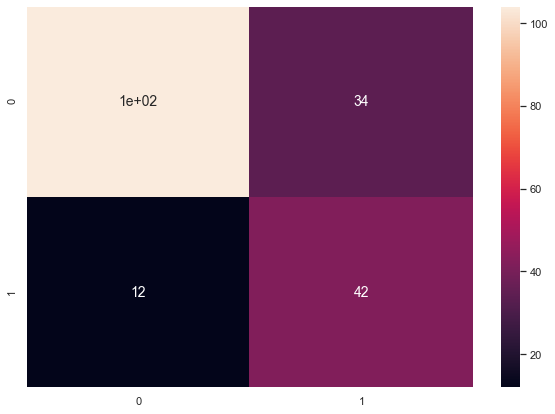

In [148]:
print("Using tanh activation function")
displayConfusionMatrix(tanhcm,plt)
plt.show()

In [149]:
print("Classification report using tanh activation function")
printClassificationReport(tanhnet, test, testt)

Classification report using tanh activation function
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       116
           1       0.78      0.55      0.65        76

    accuracy                           0.76       192
   macro avg       0.77      0.72      0.73       192
weighted avg       0.76      0.76      0.75       192

